# Módulo Experimental: Edad Media de España y CCAA
Este notebook sirve como playground para elaborar la nueva métrica **Edad Media** a partir de los datos de población del INE por edad simple.
Cruza dos fuentes:
- **INE 56940**: Cifras de población residente (Definitivas) - Histórico
- **INE 59238**: Cifras de población residente (Provisionales) - Avance


In [1]:
import pandas as pd
import numpy as np
import requests
import io
import warnings
warnings.filterwarnings('ignore')

# Desactivar advertencias de SSL para INE
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)


c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\Usuario\anaconda3\envs\tftimeseriesII\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### 1. Descarga de Datos (Definitivos y Provisionales)
Descargamos los CSV directamente de los endpoints de JaxiT3 del INE.


In [2]:
def descargar_ine_csv(tabla_id):
    url = f"https://www.ine.es/jaxiT3/files/t/es/csv_bdsc/{tabla_id}.csv"
    print(f"Descargando tabla {tabla_id}...")
    
    r = requests.get(url, verify=False, timeout=30)
    r.raise_for_status()
    
    # El INE suele usar latin1 o cp1252 y sus separadores varían.
    # En JaxiT3 suele ser delimitado por punto y coma.
    try:
        r.encoding = 'utf-8-sig'
        df = pd.read_csv(io.StringIO(r.text), sep=";")
    except:
        r.encoding = 'latin1'
        df = pd.read_csv(io.StringIO(r.text), sep=";")
        
    return df

# 56940 = Datos Definitivos
df_def = descargar_ine_csv("56940")
df_def['Tipo'] = 'Definitivo'

# 59238 = Datos Provisionales
df_prov = descargar_ine_csv("59238")
df_prov['Tipo'] = 'Provisional'

# Unir ambos universos
df_bruto = pd.concat([df_def, df_prov], ignore_index=True)
print(f"\nFilas totales importadas: {len(df_bruto):,}")
df_bruto.head()


Descargando tabla 56940...
Descargando tabla 59238...

Filas totales importadas: 1,365,540


,Edad simple,Comunidades y ciudades autónomas,Sexo,Periodo,Total,Tipo
0,Todas las edades,Total Nacional,Total,1 de enero de 2025,49.128.297,Definitivo
1,Todas las edades,Total Nacional,Total,1 de octubre de 2024,48.999.880,Definitivo
2,Todas las edades,Total Nacional,Total,1 de julio de 2024,48.821.936,Definitivo
3,Todas las edades,Total Nacional,Total,1 de abril de 2024,48.701.130,Definitivo
4,Todas las edades,Total Nacional,Total,1 de enero de 2024,48.619.695,Definitivo


### 2. Limpieza y Consolidación (Solape)
Tratamos las edades, los valores vacíos, homogenizamos las fechas y prevalecemos el dato 'Definitivo' frente al 'Provisional'.


In [3]:
df = df_bruto.copy()

# 1. Filtramos para quedarnos sólo con ambos sexos juntos para el cálculo global
df = df[df['Sexo'] == 'Total']

# 2. Limpieza de campo 'Total' (que viene con puntos de miles)
def clean_valor(v):
    if pd.isna(v): return np.nan
    v_str = str(v).replace('.', '').replace(',', '.').strip()
    try:
        return float(v_str)
    except:
        return np.nan

df['Poblacion'] = df['Total'].apply(clean_valor)

# 3. Parseo de Fecha (Periodo)
meses_map = {'enero': 1, 'abril': 4, 'julio': 7, 'octubre': 10}

def parse_periodo(p_str):
    # Formato habitual: "1 de enero de 2025" o "2021" si es anual. 
    # El INE en estas tablas para trimestres usa el formato largo '1 de [mes] de [año]'
    p_str = str(p_str).lower()
    
    # Extraer año
    import re
    match_yr = re.search(r'\d{4}', p_str)
    if not match_yr: return None
    year = int(match_yr.group())
    
    # Extraer mes
    month = 1
    for m, num in meses_map.items():
        if m in p_str:
            month = num
            break
            
    return pd.to_datetime(f"{year}-{month:02d}-01")

df['Fecha'] = df['Periodo'].apply(parse_periodo)

# 4. Solapar: En caso de que una fecha esté en Provisionales y Definitivas, prevalece Definitiva
# Ordenamos para dar prioridad: 'Definitivo' va antes que 'Provisional' en orden alfabético
df.sort_values(by=['Comunidades y ciudades autónomas', 'Edad simple', 'Fecha', 'Tipo'], inplace=True)
df.drop_duplicates(subset=['Comunidades y ciudades autónomas', 'Edad simple', 'Fecha'], keep='first', inplace=True)

print(f"Filas tras eliminar solapamientos y filtrar Sexo=Total: {len(df):,}")


Filas tras eliminar solapamientos y filtrar Sexo=Total: 455,180


### 3. Parsear Edad y Cálculo de Edad Media
Aislamos las edades para calcular la media ponderada (evitando la fila precalculada 'Todas las edades')


In [4]:
# Extraer valor numérico de Edad
def parse_edad(e_str):
    if 'Todas las edades' in str(e_str):
        return np.nan # Marcamos para excluir del cálculo
    
    # Ej: '0 años', '1 año'
    import re
    match = re.search(r'\d+', str(e_str))
    if match:
        return float(match.group())
    return np.nan

df['Edad_Num'] = df['Edad simple'].apply(parse_edad)

# Descartamos las filas resumen ('Todas las edades')
df_edades = df.dropna(subset=['Edad_Num', 'Poblacion']).copy()

# Cálculo de la media ponderada agrupando por Región y Fecha
# Formula: Sum(Edad * Poblacion) / Sum(Poblacion)
df_edades['Producto_Edad_Pob'] = df_edades['Edad_Num'] * df_edades['Poblacion']

df_agrupado = df_edades.groupby(['Comunidades y ciudades autónomas', 'Fecha']).agg(
    Suma_Producto=('Producto_Edad_Pob', 'sum'),
    Suma_Poblacion=('Poblacion', 'sum'),
    Tipo_Fuente=('Tipo', 'first') # Rastrear si el bloque final proviene de Def o Prov
).reset_index()

df_agrupado['Edad_Media'] = df_agrupado['Suma_Producto'] / df_agrupado['Suma_Poblacion']
df_agrupado.head(10)


,Comunidades y ciudades autónomas,Fecha,Suma_Producto,Suma_Poblacion,Tipo_Fuente,Edad_Media
0,01 Andalucía,1971-01-01,168571752.0,5689754.0,Definitivo,29.627248
1,01 Andalucía,1971-07-01,162161526.0,5435558.0,Definitivo,29.833464
2,01 Andalucía,1972-01-01,165743563.0,5417973.0,Definitivo,30.591434
3,01 Andalucía,1972-07-01,169454598.0,5655578.0,Definitivo,29.962384
4,01 Andalucía,1973-01-01,177331454.0,5818359.0,Definitivo,30.477916
5,01 Andalucía,1973-07-01,174382916.0,5708207.0,Definitivo,30.549508
6,01 Andalucía,1974-01-01,158045879.0,5494127.0,Definitivo,28.766332
7,01 Andalucía,1974-07-01,165811580.0,5628980.0,Definitivo,29.456772
8,01 Andalucía,1975-01-01,173962883.0,5642773.0,Definitivo,30.829325
9,01 Andalucía,1975-07-01,172987883.0,5692960.0,Definitivo,30.386281


### 4. Renombrado y Pivoteo (Estilo IPA27)
Para homologarlo, vamos a utilizar las siglas oficiales de nuestro diccionario.


Vista Previa (Métricas ESP y AND):


Region_Code,ESP,AND
Fecha,,
2023-10-01,45.217041,42.935941
2024-01-01,44.618301,44.646587
2024-04-01,45.613999,43.426772
2024-07-01,45.242765,44.566181
2024-10-01,45.086328,44.005689
2025-01-01,45.648682,44.474151
2025-04-01,44.087718,43.081718
2025-07-01,44.149850,43.159462
2025-10-01,44.197467,43.222768


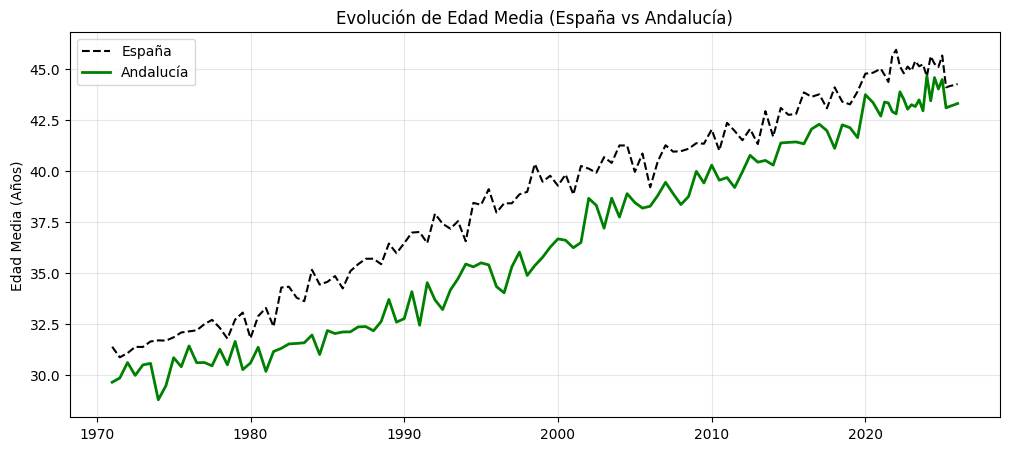

In [5]:
REGIONES_PATRONES = {
    "ESP": ["total nacional", "total españa", "españa"],
    "AND": ["andaluc"],
    "ARA": ["aragon", "aragón"],
    "AST": ["asturias"],
    "BAL": ["balears", "baleares"],
    "CAN": ["canarias"],
    "CANT": ["cantabria"],
    "CYL": ["castilla y león", "castilla y leon"],
    "CLM": ["castilla - la mancha", "castilla-la mancha", "castilla y la mancha"],
    "CAT": ["catalu"],
    "VAL": ["valencia"],
    "EXT": ["extremadura"],
    "GAL": ["galicia"],
    "MAD": ["madrid"],
    "MUR": ["murcia"],
    "NAV": ["navarra"],
    "PV": ["vasco", "euskadi"],
    "RIO": ["rioja"]
}

import unicodedata

def detector_region(texto):
    s = str(texto).lower().strip()
    s = "".join(c for c in unicodedata.normalize('NFKD', s) if unicodedata.category(c) != 'Mn')
    
    if "ceuta" in s or "melilla" in s:
        return None
        
    for acr, patrones in REGIONES_PATRONES.items():
        if any(p in s for p in patrones):
            return acr
            
    # Atrapamos por códigos numéricos de inicio si falla
    for acr, c_num in zip(["AND", "ARA", "AST", "BAL", "CAN", "CANT", "CYL", "CLM", "CAT", "VAL", "EXT", "GAL", "MAD", "MUR", "NAV", "PV", "RIO"],
                           ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15", "16", "17"]):
        if s.startswith(c_num): return acr
        
    return None

df_agrupado['Region_Code'] = df_agrupado['Comunidades y ciudades autónomas'].apply(detector_region)
df_final = df_agrupado.dropna(subset=['Region_Code']).copy()

# Pivotamos para que el formato final sea exactamente el esperado (Fecha index, Regiones columnas)
df_pivot = df_final.pivot(index='Fecha', columns='Region_Code', values='Edad_Media')

# Validamos
print("Vista Previa (Métricas ESP y AND):")
display(df_pivot[['ESP', 'AND']].tail(10))

# Plot rápido
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(df_pivot.index, df_pivot['ESP'], label='España', color='black', linestyle='--')
plt.plot(df_pivot.index, df_pivot['AND'], label='Andalucía', color='green', linewidth=2)
plt.title('Evolución de Edad Media (España vs Andalucía)')
plt.ylabel('Edad Media (Años)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()


### 5. Empaquetado de la Función (Output)
Dejamos listo el bloque de código final en forma de función "drop-in" para llevárnoslo al notebook oficial cuando queramos.


In [ ]:
def extraer_edad_media_ine():
    """
    Descarga, solapa y calcula la Edad Media de la población para las CCAA y España
    basado en las tablas del INE (56940 definitivos y 59238 provisionales).
    """
    # Lógica que usaríamos en el script principal para inyectar este DataFrame al Excel o proceso
    # ...
    pass
